# Example of network perturbation elasticity calculation for statins

**Author:** Pablo Carbonell, SYNBIOCHEM, University of Manchester, 2016

**Description:** This code shows how to estimate perturbation level in hepatocytes from gene expression data based on a genome-scale of the cell.

**How to cite:** P. Carbonell, O. Lopez, A. Amberg, M. Pastor, F. Sanz, Network perturbation elasticity-based drug toxicity prediction and its application to hepatotoxicity, 2016.

In [1]:
# Libraries and data files
from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
%matplotlib inline
from collections import defaultdict as dd
import re
from re import sub
from os import path
from glob import glob

datafolder = 'data'
# These are the GPR association rules extracted from Recon 2
rassoc = path.join(datafolder, 'regenassoc.txt')
# Gene name space mapping
rgenes = path.join(datafolder, 'gnames.txt')
# Pathway information for reactions annotated in Recon @
rpath = path.join(datafolder, 'rpath.txt')
# Gene differential expression for statins downloaded from LINCS (L100 set)
statinlincs = path.join(datafolder, 'statin.txt')
# Gene information downloaded from HumanCyc
hgenes = path.join(datafolder, 'All_genes_of_H._sapiens.xls')
# FVA values for reactions in the hepatocyte model (see compute_fva.py)
fvaliver = path.join(datafolder, 'liver_hepatocytes.fva')

cid = {'BRD-A71816415': 'pravastatin', 'BRD-K22134346': 'simvastatin', 'BRD-K82941592': 'rosuvastatin'}

In [3]:
pravastatin = Chem.MolFromSmiles("CCC(C)C(=O)OC1CC(O)C=C2C=CC(C)C(CCC(O)CC(O)CC(O)=O)C12")
simvastatin = Chem.MolFromSmiles("CCC(C)(C)C(=O)OC1CC(C)C=C2C=CC(C)C(CCC3CC(O)CC(=O)O3)C12")
rosuvastatin = Chem.MolFromSmiles("CC(C)c1nc(nc(c1/C=C/[C@@H](O)C[C@@H](O)CC(=O)O)c2ccc(F)cc2)N(C)S(=O)(=O)C")


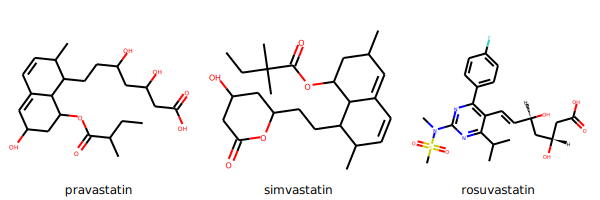

In [4]:
Chem.Draw.MolsToGridImage([pravastatin, simvastatin, rosuvastatin],molsPerRow=3,
                     legends=['pravastatin', 'simvastatin', 'rosuvastatin'])

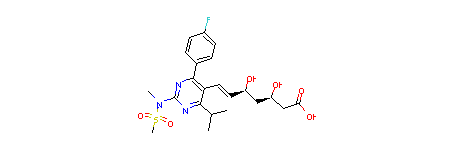

In [76]:
rosuvastatin

In [6]:
# Operations dealing with gene-protein-reaction rules in the model

class rule:
    """ Class for computing GPR rules
    """
    def __init__(self):
        self.items = []
        self.ops = []
        self.genes = set() # keep the list of involved genes

    def add_genes(self, g):
        if type(g) == set:
            self.genes |= g
        else:
            self.genes.add(g)
    
    def add_op(self, op):
        self.ops.append(op)

    def add_items(self, y):
        self.items.append(y)

    def operation(self, v1, v2, op):
        if v1 is None:
            return v2
        elif v2 is None:
            return v1
        if op == 'and':
            return min(v1,v2)
        elif op == 'or':
            return max(v1,v2)
        else:
            return None

    # hash with values for each gene
    # if missing==None, they are ignored, otherwise provide default value
    def compute(self, val, missing=None):
        """ Compute recursively rules
        """
        t = self.items[0]
        if type(t) == str:
            if t in val:
                v = val[t]
            else:
                v = missing
        else:
            v = t.compute(val, missing)
        for i in range(1, len(self.items)):
            t = self.items[i]
            if type(t) == str:
                if t in val:
                    v1 = val[t]
                else:
                    v1 = missing
            else:
                v1 = t.compute(val, missing)
            op = self.ops[i-1]
            v = self.operation(v, v1, op)
        return v
            

def parse_rule(s):
    """ Parse rules as given in the model
    """
    m = s.split()
    r = rule()
    i = 0
    while i < len(m):
        x = m[i]
        if x.startswith('('):
            s1 = ''.join(list(x)[1:len(x)])
            while not s1.endswith(')'):
                i += 1
                if len(m) == i:
                    break                
                s1 += ' '+m[i]
            s1 = ''.join(list(s1)[0:(len(s1)-1)])
        else:
            s1 = m[i]
        if len(s1.split()) > 1:
            r1 = parse_rule(s1)
            r.add_genes(r1.genes)
        else:
            r1 = s1
            r.add_genes(s1)
        r.add_items(r1)
        i += 1
        if i < len(m):
            r.add_op(m[i])
            i += 1
    return r

def gene_rules(rassoc):
    """ Return a dictionary of gene-reaction rules
    """
    rl = {}
    for l in open(rassoc):
        m = l.rstrip().split('\t')
        rl[m[0]] = parse_rule(m[1])
    return rl


In [7]:
# Read information about the metabolic model for liver hepatocytes

def recon_genes(rgenes):
    """ Retrieve genes in the metabolic model
    """
    lg = {}
    gl = {}
    for l in open(rgenes):
        m = l.split()
        gl[m[1]] = m[0]
        lg[m[0]] = m[1]
    return gl, lg

def recon_paths(rpath):
    """ Retrieve pathways in the metabolic model
    """
    rp = {}
    for l in open(rpath):
        m = l.rstrip().split('\t')
        if m[0] not in rp:
            rp[m[0]] = set()
        rp[m[0]].add(m[1])
    return rp

def fva_cell(fvaliver):
    """ Read Flux Variability Analysis for liver hepatocytes
    """
    fv = {}
    cn = sub('.fva', '', path.basename(fvaliver))
    fv[cn] = {}
    for l in open(fvaliver):
        m = l.split()
        fv[cn][m[0]] = (float(m[1]), float(m[2]))
    return fv

def lincs_reg(lincsfile):
    """ Read information regarding LINCS gene expression
    """
    grr = dd(lambda: dd(int))
    gl = set()
    for l in open(lincsfile):
        m = l.rstrip().split('|')
        grr[m[0]][m[1]] = int(m[2])
        gl.add(m[1])
    return grr, gl

def human_genes(hgenes):
    """ Read information about genes
    """
    hm = {}
    for l in open(hgenes):
        m = l.rstrip().split('\t')
        m[0] = re.sub('"', '', m[0])
        try:
            m[1] = re.sub('"', '', m[1])
        except:
            m.append('')
        hm[m[0]] = m[1]
    return hm


In [8]:
# Read data

rl = gene_rules(rassoc)
rg, gr = recon_genes(rgenes)
rp = recon_paths(rpath)
fv = fva_cell(fvaliver)
grr, gl = lincs_reg(statinlincs)
hm = human_genes(hgenes)

In [9]:
# Table with gene regulation

header = ['gene','gene name']+list(map(lambda x: cid[x], sorted(grr)))
df = pd.DataFrame(columns=header)
for g in sorted(gl):
    v = []
    v.append(g)
    if g in hm:
        v.append(hm[g])
    else:
        v.append('-')
    for c in sorted(grr):
        if g in grr[c]:
            v.append( grr[c][g])
        else:
            v.append('-')
    df.loc[len(df)] = list(map(str, v))
df




,gene,gene name,pravastatin,simvastatin,rosuvastatin
0,AARS,"Alanyl-tRNA synthetase, cytoplasmic",-1,-,-
1,ABCF1,ATP-binding cassette sub-family F member 1,-1,-1,-
2,ACAA1,"3-ketoacyl-CoA thiolase, peroxisomal",-,-,1
3,ACAT2,acetyl-CoA acetyltransferase,-,1,1
4,ADCK3,chaperone activity of bc1 complex-like,1,-,-
5,ADI1,"1,2-dihydroxy-3-keto-5-methylthiopentene dioxy...",-1,-,-
6,ADO,cysteamine dioxygenase,-,-,1
7,AKAP8L,A-kinase anchor protein 8-like,1,1,1
8,AKR7A2,Aflatoxin B1 aldehyde reductase member 2,-,-,1
9,ALDOC,fructose-bisphosphate aldolase C monomer,-,1,-


In [10]:
# Table with reaction regulation, flux variability and pathway information

pstats = dd(lambda: dd(int))                

d = dd(lambda: dd(list))
rinfo = {}
for r in rl:
    for c in sorted(grr):
        gll = {}
        for g in grr[c]:
            if g in gr:
                gll[gr[g]] = grr[c][g]
        
        ex = rl[r].compute(gll)
        if ex is not None:
            fvv = fv['liver_hepatocytes']
            rr = sub('R_', '', r)
            if rr in fvv:
                d[r][c] =  ex
                lb = "%.2f" % (fvv[rr][0],)
                ub = "%.2f" % (fvv[rr][1],)
                rinfo[r] = [lb, ub, ','.join(rp[r])]
                for p in rp[r]:
                    pstats[p][c] += 1

header = ['reaction']+list(map(lambda x: cid[x], sorted(grr)))+[ 'lb', 'up', 'pathway']
df = pd.DataFrame(columns=header)
for r in sorted(d):
    v = []
    v.append(r)
    for c in sorted(grr):
        if c in d[r]:
            v.append(d[r][c])
        else:
            v.append('-')
    v += rinfo[r]
    df.loc[len(df)] = list(map(str,v))
df

,reaction,pravastatin,simvastatin,rosuvastatin,lb,up,pathway
0,R_2OXOADOXm,-1,-1,-,0.00,3.00,Lysine metabolism
1,R_ACACT1r,-,1,1,-1000.00,333.67,Tryptophan metabolism
2,R_ACACT1x,-,1,1,0.00,774.83,Cholesterol metabolism
3,R_ACACT4p,-,-,1,0.00,501.48,Fatty acid oxidation
4,R_ACACT5p,-,-,1,0.00,501.48,Fatty acid oxidation
5,R_ACACT6p,-,-,1,0.00,501.48,Fatty acid oxidation
6,R_ACACT7p,-,-,1,0.00,501.48,Fatty acid oxidation
7,R_ALR2,-,-,1,0.00,1000.00,Pyruvate metabolism
8,R_ALR3,-,-,1,0.00,1000.00,Pyruvate metabolism
9,R_ARABR,-,-,1,0.00,1.00,Pentose phosphate pathway


In [42]:
def regulation(reg, lb, up):
    S = 0
    for i in range(0, len(reg)):
        try:
            r = float(reg[i])
        except:
            continue
        if r < 0:
            S += r*float(lb[i])
        else:
            S += r*float(up[i])
    return S
regulation(df['rosuvastatin'], df['lb'], df['up']) 
cn = sorted(cid.values())
reg = {}
for c in sorted(cid.values()):
    v = regulation(df[c], df['lb'], df['up'])
    reg[c] = v
    print(c, v)

pravastatin 10160.48
rosuvastatin 27857.22
simvastatin 13254.199999999999


In [12]:
# Summary table for pathway information

df1 = pd.DataFrame(columns= ['pathway']+ list(map(lambda x: cid[x], sorted(cid))))
for p in sorted(pstats):
    df1.loc[len(df1)] = ([p]+list(map(lambda x: str(pstats[p][x]), sorted(cid))))
df1

,pathway,pravastatin,simvastatin,rosuvastatin
0,Arginine and Proline Metabolism,1,0,0
1,Bile acid synthesis,1,0,0
2,Cholesterol metabolism,2,8,9
3,CoA catabolism,0,0,1
4,CoA synthesis,0,0,1
5,Fatty acid oxidation,3,4,45
6,Fructose and mannose metabolism,0,2,1
7,Glutamate metabolism,1,1,1
8,"Glycine, serine, alanine and threonine metabolism",1,1,1
9,Glycolysis/gluconeogenesis,1,2,0


<Container object of 3 artists>

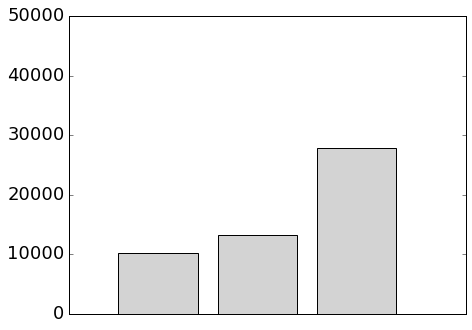

In [78]:
# Bar plot
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(640/90,480/90), dpi=150)
ax = fig.add_subplot(111, xlim=[0.5,4.5], ylim=[0,5e4], xticks=[])
# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', labelsize=18)
ax.tick_params(axis='both', which='minor', labelsize=8)
zv = np.array(list(map(lambda x: reg[x], ['pravastatin', 'simvastatin', 'rosuvastatin'])))
ax.bar([1,2,3],zv, color='lightgray')
